# Projet d'apprentissage profond pour les images PART 2 - Quang-Duy Nguyen, Morgan Ramadani
## image.png

## Installation & Imports

In [6]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import random
# Deprecated
# from keras.preprocessing.image import save_img
from keras.utils import save_img
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from keras.preprocessing.image import save_img
    # from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    save_img("%s.png" % name, image, file_format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels, set='train'):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/'+ str(set) + '/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" :
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    # with open(DATA_PATH) as f:
        # image = read_single_image(f)
        # plot_image(image)

    # test to check if the whole dataset is read correctly
    # images = read_all_images(DATA_PATH)
    # print(images.shape)

    # labels = read_labels(LABEL_PATH)
    # print(labels.shape)

    # save images to disk
    # save_images(images, labels)
    pass

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [7]:
# path to the binary files with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
DATA_TEST_PATH = './data/stl10_binary/test_X.bin'

# path to the binary files with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
LABEL_TEST_PATH = './data/stl10_binary/test_y.bin'

In [8]:
# Loading image data
images = read_all_images(DATA_PATH)
test_images = read_all_images(DATA_TEST_PATH)

labels = read_labels(LABEL_PATH)
test_labels = read_labels(LABEL_TEST_PATH)

## Data Exploration

In [9]:
# Check if there is class imbalance
print(np.array(np.unique(labels, return_counts=True)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


Classes are well balanced

In [10]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [11]:
# Splitting train data into 80% train, 20% validation splits
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42,stratify=labels)

# One hot encode the labels (not here because we need to adapt to pytorch standards)
num_classes = 10
# train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
# val_labels = tf.keras.utils.to_categorical(val_labels-1, num_classes)
# test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Check the data sets shape
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, val_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)


Training set: (4000, 96, 96, 3) (4000,)
Validation set: (1000, 96, 96, 3) (1000,)
Test set: (8000, 96, 96, 3) (8000,)


## Data Augmentation

### Horizontal Flip

In [12]:
flipped_img = np.empty_like(train_images)

for i in range(train_images.shape[0]):
    flipped_img[i] = np.fliplr(train_images[i])

In [13]:
train_images = np.append(train_images,flipped_img,axis=0)
train_labels = np.append(train_labels,train_labels,axis=0)

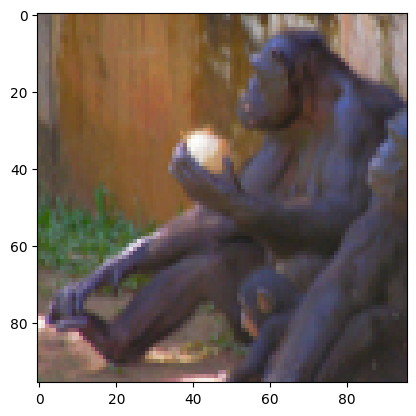

In [14]:
i = random.randint(0,5400)
# i = 0
plot_image(train_images[i])
if i - 4000 >= 0:
    plot_image(train_images[i-4000])
else :
    plot_image(train_images[i+4000])

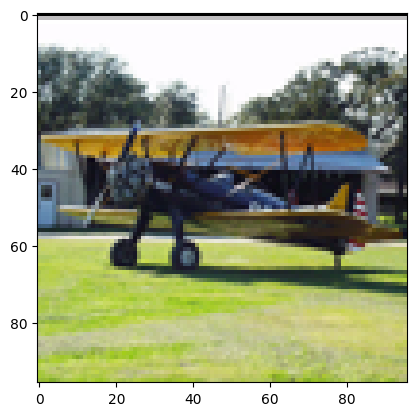

1

In [15]:
plot_image(val_images[80])
val_labels[80]

In [16]:
print(train_images.shape)
print(train_labels.shape)

(8000, 96, 96, 3)
(8000,)


### Translation, Shearing, Zooming: Zoom in or out on the image.

In [17]:
# Preprocessing function to add random noise
def add_random_noise(x):
    noise = np.random.normal(0, 0.1, x.shape)  # Generate random noise
    noisy_image = x + noise  # Add noise to the image
    return noisy_image

# Preprocessing function to adjust contrast
def adjust_contrast(x):
    return x
    # contrast_factor = np.random.uniform(0.8, 1.2)  # Adjust contrast by random factor
    # adjusted_image = (x - np.mean(x)) * contrast_factor + np.mean(x)
    # return adjusted_image

def gaussian_blur(x):
    if random.random() <= 0.5 :
        return cv2.GaussianBlur(x, (3, 3), 0)
    else :
        return x

In [18]:
step2 = ImageDataGenerator(
    width_shift_range=0.2,  # Random horizontal shift by 20% of image width
    height_shift_range=0.2,  # Random vertical shift by 20% of image height
    zoom_range=0.2,  # Random zoom in/out by 20%
    shear_range=0.2,
    brightness_range=[0.9, 1.1],  # Random brightness adjustment between 0.5 and 1.5
    preprocessing_function=lambda x: gaussian_blur(adjust_contrast(add_random_noise(x))),  # Gaussian blur with kernel size of (3, 3)
    fill_mode= 'constant'
)

In [19]:
# numbers of images generated
aug_num = 16000

In [20]:
augmented_generator = step2.flow(train_images.reshape((-1, 96, 96, 3)), train_labels, batch_size=1)

# Generate augmented images and corresponding labels
augmented_images = []
augmented_labels = []
num_augmented_images = 0

for _ in range(aug_num):
    batch = augmented_generator.next()
    augmented_images.append(batch[0][0].astype(np.uint8))
    augmented_labels.append(batch[1])
    num_augmented_images += 1

# Convert the augmented images and labels back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Verify the shape of the augmented images and labels
print(augmented_images.shape)
print(augmented_labels.shape)



(16000, 96, 96, 3)
(16000, 1)


In [21]:
# Reshape labels to correct format
augmented_labels = augmented_labels.reshape(aug_num)

In [22]:
print(augmented_images.shape)
print(augmented_labels.shape)

(16000, 96, 96, 3)
(16000,)


In [23]:
train_images = np.append(train_images,augmented_images,axis=0)
train_labels = np.append(train_labels,augmented_labels,axis=0)

In [24]:
train_images.shape, train_labels.shape

((24000, 96, 96, 3), (24000,))

In [ ]:
# Save images to the directory in order to load the dataset in the dataloader
save_images(train_images,train_labels,set='train')

In [ ]:
save_images(val_images, val_labels, set ='val')

In [ ]:
save_images(test_images, test_labels, set ='test')

## Models

### Use ViT to learn from images

In [ ]:
!pip install vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=77245572c068318b85faf52b1c3452dfb8ce6fc79fe5c2bd88283216fd2c20d5
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit
from tensorflow.keras import Model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
base_model = vit.vit_b32(
    image_size=96,  # Input image size
    # activation='softmax',  # Output activation function
    pretrained=True,  # Whether to use pre-trained weights
    include_top=False,  # Include classification head
    pretrained_top=False,  # Use pre-trained weights for classification head
    classes=10  # Number of classes for classification
)
# Freeze the base model layers
base_model.trainable = False

# Add a new classification head
x = base_model.output
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)
for layer in model.layers[:-2]:
  layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 3, 3
  warnings.warn(


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 3, 3, 768)         2360064   
                                                                 
 reshape_1 (Reshape)         (None, 9, 768)            0         
                                                                 
 class_token (ClassToken)    (None, 10, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 10, 768)          7680      
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 10, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

We can see above that only the last two layers are trainable. There are arround 200K parameters trainable which are the sum of parameters from dens_7 and dense_8. Those are the layers that we have defined.

In [ ]:
model.fit(train_images, train_labels, batch_size = 128, epochs=20,
          validation_data=(val_images, val_labels),validation_batch_size=1000,validation_freq = 5)

Epoch 1/20
125/125 [==============================] - 20s 95ms/step - loss: 1.9605 - accuracy: 0.2672
Epoch 2/20
125/125 [==============================] - 12s 100ms/step - loss: 1.7604 - accuracy: 0.3368
Epoch 3/20
125/125 [==============================] - 13s 102ms/step - loss: 1.6780 - accuracy: 0.3672
Epoch 4/20
125/125 [==============================] - 12s 98ms/step - loss: 1.6316 - accuracy: 0.3909
Epoch 5/20
125/125 [==============================] - 15s 122ms/step - loss: 1.6033 - accuracy: 0.4006 - val_loss: 1.6363 - val_accuracy: 0.3960
Epoch 6/20
125/125 [==============================] - 12s 95ms/step - loss: 1.5631 - accuracy: 0.4171
Epoch 7/20
125/125 [==============================] - 12s 96ms/step - loss: 1.5393 - accuracy: 0.4264
Epoch 8/20
125/125 [==============================] - 12s 97ms/step - loss: 1.5067 - accuracy: 0.4404
Epoch 9/20
125/125 [==============================] - 12s 98ms/step - loss: 1.4833 - accuracy: 0.4489
Epoch 10/20
125/125 [================

We constantly obtained low validation accuracy. We will not proced with this model.

### CLIP Feature Extraction

In [29]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9gklcolq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9gklcolq
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=ba8588b2a75d83be076c283fa7db9cff8d8ccfff55fd74eb30150c3be1189f20
  Stored in directory: /tmp/pip-ephem-wheel-cache-i3u0slv8/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [30]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder,ImageFolder
from torchvision.datasets import CIFAR100
from tqdm import tqdm
import torchvision.transforms as transforms

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 296MiB/s]


In [31]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a size  appropriate for the model
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image pixel values
])

train_folder = "./img/train/"
val_folder = "./img/val/"
test_folder = "./img/test/"

# Create an instance of ImageFolder dataset
train_dataset = ImageFolder(train_folder, transform=transform)
val_dataset = ImageFolder(val_folder, transform=transform)
test_dataset = ImageFolder(test_folder, transform=transform)

# Create a DataLoader to load the dataset
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [32]:
def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [33]:
# Calculate the image features
train_features, train_labels = get_features(train_dataset)
val_features, val_labels = get_features(val_dataset)
test_features, test_labels = get_features(test_dataset)

100%|██████████| 80/80 [00:22<00:00,  3.55it/s]


We will now proceed to the classification on the extracted features with the help of machine learning algorithmes

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris

# Create an instance of LogisticRegression
logreg = LogisticRegression(random_state=0, max_iter=1500, verbose=1,n_jobs=-1)

# Define the hyperparameters and their values for grid search
param_grid = {
    'C': [0.1, 0.3, 0.6, 1.0, 10.0]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Best hyperparameters:  {'C': 1.0}
Best score:  0.9744999999999999


In [38]:
# Create an instance of LogisticRegression
logreg = LogisticRegression(random_state=0, max_iter=1500, verbose=1,n_jobs=-1, C=1)

logreg.fit(train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(C=1, max_iter=1500, n_jobs=-1, random_state=0, verbose=1)

In [39]:
# Evaluate using the RF classifier
predictions_logreg = logreg.predict(test_features)
accuracy_logreg = np.mean((test_labels == predictions_logreg).astype(float)) * 100.
print(f"Accuracy_logreg = {accuracy_logreg:.3f}")

Accuracy_logreg = 97.938


In [36]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
classifier = RandomForestClassifier(random_state=0, n_jobs=-1)

In [43]:
classifier.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [44]:
# Evaluate using the RF classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 97.862


We obtained really good results with the use of the model CLIP for feature extraction. We invite you to see the main notebook for conclusion